In [1116]:
import sys
sys.path.append('../python')
sys.path.append('../4jupy/lib/python3.6/site-packages/')
import numpy as np
import pandas as pd
import xarray as xr
from data import Data
from geo import cells
from mapping import proj_params, cartopy_params, affine
from warnings import catch_warnings, simplefilter
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
%matplotlib nbagg

In [2]:
D = Data('../python/data.cfg')
D.open('c','station_data.h5')
D.open('d','prDaily.h5')

In [3]:
# CEAZA
r = D.c['pp_mm'].xs('prom', 1, 'aggr')
sta = D.sta.loc[r.columns.get_level_values('station')]

In [891]:
# DGA
r = D.d['prDaily']
sta = r.columns.to_series().reset_index()[['nombre', 'longitud', 'latitud']]
sta.index = r.columns.get_level_values('codigo_estacion')
sta.columns = ['name', 'lon', 'lat']

In [1051]:
g5 = conc(r, ps(a5, False), 'codigo_estacion', dt=4)
g6 = conc(r, ps(a6, False), 'codigo_estacion', dt=16)

In [869]:
with xr.open_dataset('../../data/WRF/3d/geo_em.d03.nc') as d3:
    lm = d3['LANDMASK'].squeeze().load()
    clon, clat = d3['XLONG_C'].squeeze().load(), d3['XLAT_C'].squeeze().load()
    lon, lat = d3['XLONG_M'].squeeze().load(), d3['XLAT_M'].squeeze().load()
    dom3 = proj_params(d3)

i, j, k = cells(clon, clat, *sta[['lon', 'lat']].astype(float).values.T)
sta = sta.drop(sta.index[k])
r = r[sta.index]

def ps(x, mean=True):
    y = x.sel_points(south_north=i, west_east=j)
    y.coords['stations'] = ('points', sta.index)
    y = y.swap_dims({'points': 'stations'})
    if mean:
        m = x.mean(['south_north', 'west_east'])
        m.expand_dims('stations')
        m['stations'] = 'mean'
        y = y.drop(list(set(y.coords) - set(m.coords)))
        return xr.concat((y, m), 'stations')
    return y

In [271]:
d5 = xr.open_dataset('../../data/WRF/3d/RAINNC_5.nc')
#d5 = xr.open_dataset('../python/RAINNC_5.nc')
x = d5['RAINNC'].isel(Time = np.arange(24, 121, 24))
x5 = xr.concat((x.isel(Time = 0), x.diff('Time')), 'Time')
a5 = d5['RAINNC'].diff('Time')

d6 = xr.open_dataset('../../data/WRF/3d/RAINNC_6.nc')
#d6 = xr.open_dataset('../python/RAINNC_6.nc')
x = d6['RAINNC'].sel(start=slice(None, '2017-07-21'))
x6 = x.isel(Time = np.arange(24, 145, 24))
x6 = xr.concat((x6.isel(Time = 0), x6.diff('Time')), 'Time')
a6 = x.diff('Time')

In [33]:
# This uses proper calendar days
y5 = d5['RAINNC'].isel(Time = np.arange(4, 121, 24))
y5 = xr.concat((y5.isel(Time = 0), y5.diff('Time')), 'Time')

x = d6['RAINNC'].sel(start=slice(None, '2017-07-21'))
y6 = x.isel(Time = np.arange(16, 145, 24))
y6 = xr.concat((y6.isel(Time = 0), y6.diff('Time')), 'Time')

<xarray.DataArray 'XTIME' (start: 310, Time: 5)>
array([['2015-05-19T00:00:00.000000000', '2015-05-20T00:00:00.000000000',
        '2015-05-21T00:00:00.000000000', '2015-05-22T00:00:00.000000000',
        '2015-05-23T00:00:00.000000000'],
       ['2015-05-20T00:00:00.000000000', '2015-05-21T00:00:00.000000000',
        '2015-05-22T00:00:00.000000000', '2015-05-23T00:00:00.000000000',
        '2015-05-24T00:00:00.000000000'],
       ['2015-05-21T00:00:00.000000000', '2015-05-22T00:00:00.000000000',
        '2015-05-23T00:00:00.000000000', '2015-05-24T00:00:00.000000000',
        '2015-05-25T00:00:00.000000000'],
       ..., 
       ['2016-04-23T00:00:00.000000000', '2016-04-24T00:00:00.000000000',
        '2016-04-25T00:00:00.000000000', '2016-04-26T00:00:00.000000000',
        '2016-04-27T00:00:00.000000000'],
       ['2016-04-24T00:00:00.000000000', '2016-04-25T00:00:00.000000000',
        '2016-04-26T00:00:00.000000000', '2016-04-27T00:00:00.000000000',
        '2016-04-28T00:00:00.0

In [272]:
def offset_daily(x, delta):
    """
    Resample hourly observations to daily, matching WRF simulation days 
    (which start at 8:00h local time / previously 20:00h). 
    The default -8h offset means the timestamp on the resampled series refers 
    to the beginning of a 24h period starting at 8:00.
    """
    y = x.copy()
    y.index += pd.Timedelta(delta)
    return y.resample('D').mean() * 24

def loss(obs, mod, offset='MS'):
    o = obs.resample(offset).mean().mean(1).dropna()
    o.name = 'obs'
    def lead(n):
        m = mod.isel(Time=n)
        m['start'] = m.start + pd.Timedelta(n, 'd')
        return m.resample(offset, 'start', how='mean').to_series()
    r = np.arange(len(mod.Time))
    return pd.concat([lead(n) for n in r], 1, keys=r).dropna(0, 'all').join(o, how='inner')

In [89]:
# NOTE: the timestap on model data now refers to the *end* of a period - adjust offset_daily accordingly
def point_diff(obs, mod, sample='D', time_dim='ultima_lectura'):
    def lead(x, n):
        y = x.isel(Time=n).dropna('start','all')
        return xr.DataArray(y.values, coords=[('points', y.points), ('time', y.XTIME)])
    m = xr.concat([lead(mod, n) for n in range(len(mod.Time))], 'lead').resample(sample, 'time', how='mean')
    o = xr.DataArray(obs.resample(sample).mean())
    o.coords['points'] = ('dim_1', np.arange(len(o.dim_1)))
    o = o.swap_dims({'dim_1': 'points'}).rename({time_dim:'time'}).drop('dim_1')
    # i = pd.DatetimeIndex(m.time.values).intersection(pd.DatetimeIndex(o.time.values))
    # return xr.concat((o.sel(time=i), m.sel(time=i)), pd.Index(['obs', 'mod'], name='type'))
    return xr.concat((o, m), pd.Index(['obs', 'mod'], name='source'))

In [407]:
def hourly(mod, obs):
    o = obs.copy()
    o.name = 'obs'
    def lead(y, n):
        x = y.isel(Time=slice(n*24, (n+1)*24)).stack(t=('start', 'Time')).transpose('t', 'points')
        return pd.DataFrame(x.values, index=x.XTIME, columns=[n]).dropna()
    return pd.concat([lead(mod, n) for n in range(len(mod.Time)//24)], 1).join(o, how='inner')

In [273]:
rs = r.mean(1).dropna()
m5 = ps(x5).mean('points')
m6 = ps(x6).mean('points')
lm = [loss(offset_daily(r, o), k) for o, k in [('-20h', m5), ('-8h', m6)]]
ld = [loss(offset_daily(r, o), k, 'D') for o, k in [('-20h', m5), ('-8h', m6)]]
lh = [hourly(ps(a).mean('points'), rs) * 24 for a in [a5, a6]]

NameError: name 'hourly' is not defined

In [1046]:
def conc(obs, mod, station_level='stations', dt=0):
    if dt==0:
        def lead(y, n):
            m = y.isel(Time=slice(n*24, (n+1)*24)).stack(t=('start', 'Time'))
            m['t'] = m.XTIME
            m.name = n
            return m.drop(set(m.coords) - {'t'}).dropna('t')
        k = np.arange(len(mod.Time)//24)
    else:
        def lead(y, n):
            m = y.isel(Time=slice(n*24+dt, (n+1)*24+dt))
            t = m.XTIME.values[:, 0] - np.timedelta64(1, 'h')
            m = m.sum('Time')
            m['start'] = t
            m.name = n
            return m.rename({'start': 't'}).dropna('t')
        k = np.arange((mod.Time[-1] - dt)//24)
    m = xr.concat([lead(mod, n) for n in k], pd.Index(k, name='lead'))
    o = xr.DataArray(obs, coords=[('t', obs.index), ('stations', obs.columns.get_level_values(station_level))])
    o.expand_dims('lead')
    o['lead'] = 'obs'
    return xr.concat((o, m), 'lead')

In [282]:
def offset(r, dt):
    s = r.copy()
    s.index += pd.Timedelta(dt)
    return s

In [5]:
a5 = xr.open_dataarray('../../data/WRF/3d/RAINNC_5_diff.nc')
a6 = xr.open_dataarray('../../data/WRF/3d/RAINNC_6_diff.nc')
b5 = ps(a5)
b6 = ps(a6)

/usr/local/lib/python3.6/site-packages/xarray/core/duck_array_ops.py:124: FutureWarning: In the future, 'NAT == x' and 'x == NAT' will always be False.
  flag_array = (arr1 == arr2)


In [827]:
R = r.copy()
R['mean'] = R.mean(1)
l5 = conc(R, b5)*24
l6 = conc(R, b6)*24

In [834]:
def diff(x):
    o = x.sel(lead='obs')
    m = x.drop('obs', 'lead').dropna('t', 'all')
    return xr.concat((m - o, o), 'lead').sel(t=m.t)
def err(x, sample, order):
    f = {
        'space': lambda y: y.mean('stations'),
        'time': lambda y: y.resample(sample, 't', how='mean'),
        'diff': lambda y: diff(y),
        'abs': lambda y: np.abs(y)
    }
    for o in order:
        x = f[o](x)
    return pd.Series(x.mean('t'), index=x.lead)
def err_all(x, order=['space', 'diff', 'time', 'abs']):
    return pd.DataFrame({s: err(x, s, order) for s in ['MS', 'D', 'h']})[['MS', 'D', 'h']]

In [1042]:
def bplot(h, legend=None, loc='best', cmap='Accent'):
    cm = plt.get_cmap(cmap, len(h.order) if hasattr(h, 'order') else 1)
    cols = pd.Series(index=h.x.to_index())
    i = 0
    ticks, labels = [], []
    ax = plt.gca()
    for n, c in cols.iteritems():
        obs = h.sel(x=n, lead='obs')
        b = h.sel(x=n).drop('obs', 'lead').dropna('lead', 'all').squeeze()
        a = b.lead.values.astype(int)
        j = a + i
        if hasattr(b, 'order'):
            m = b.order.values.astype(int)
            s = np.sin(m*np.pi/2) / 6
            # argsort returns the indexes of the first, second, third etc. - *NOT* the order of the element
            for k, o in list(b.argsort(0).groupby('order'))[::-1]:
                plt.bar(j + s[k], b.isel_points(order=o, lead=a), color=cm(o), width=.5)
            ax.hlines(obs.sel(order=m), j[0]-1, j[-1]+1, colors=cm(m))
            plt.legend(*zip(*[(plt.Rectangle((0, 0), 1, 1, fc=cm(k)), legend[k])
                              for k in range(len(h.order))]), loc=loc)
        else:
            plt.bar(j, b, color=cm(0))
            ax.hlines(obs, j[0]-1, j[-1]+1, colors=cm(0))
        i = j[-1] + 2
        ticks.extend(j)
        labels.extend(a+1)
        if isinstance(n, tuple):
            # use 'data' coordinates for the center-x location, but 'offset points' for the y-shift
            # https://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.annotate
            ax.annotate(n[1], (j.mean(), 0), xytext=(0,-24), textcoords='offset points', ha='center')
        cols[n] = j.mean()
    ax.tick_params(length=0, labelsize=10)
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels)
    for n, c in cols.astype(float).mean(level=0).iteritems():
        ax.annotate(n, (c, 0), xytext=(0,-36), textcoords='offset points', ha='center')

In [1113]:
order_list = [['diff', 'abs', 'space', 'time'],
              ['diff', 'abs', 'time', 'space'],
              ['diff', 'space', 'time', 'abs'],
              ['diff', 'time', 'space', 'abs'],
              ['space', 'time', 'diff', 'abs'], 
              ['time', 'space', 'diff', 'abs']]
frames = [pd.concat([err_all(l.drop('mean', 'stations'), order) for l in [l5, l6]], 1, keys=['0h', '12h']) 
          for order in order_list]
h = xr.concat([xr.DataArray(f.swaplevel(axis=1)[['MS', 'D', 'h']], dims=['lead', 'x']) for f in frames], 'order')

<IPython.core.display.Javascript object>


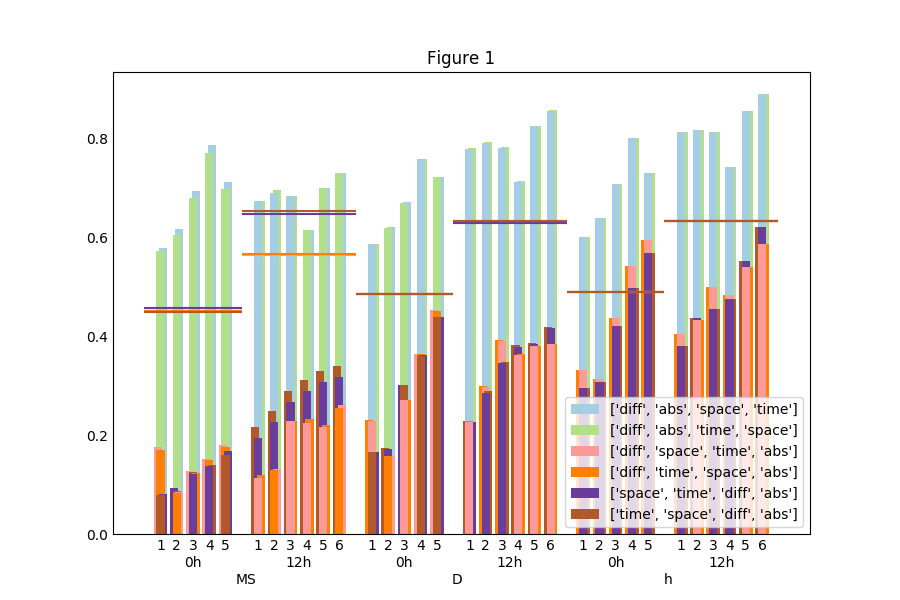

In [1117]:
fig = plt.figure(figsize=(9, 6))
bplot(h, order_list, 'lower right', 'Paired')
plt.gca().set_title('Figure 1');

The horizontal lines mark the observed values after applying the same sequence of (spatial, temporal) averaging as for the differences between simulations and observations.

**12h / MS**: Difference in mean due to lack of simulations in 2016/04-2016/06 (Fig. 2, Tab. 1): applying 'diff' means selecting only times for which both observations and simulations are available. For the monthly aggration, the weight of months with missing days is much higher in the overall average than for shorter aggragations, where the weight is spread more evenly.  
**0h / lead 1**: This appears to be due mainly to some missing simulation dates during rain events (2015/08) (Fig.3)  
**First differencing vs first averaging**: First differencing means that only (hourly) times for which both simulations and observations (for each location) enter the statistics, while first applying some (spatial, temporal) average means that the unavailability is somewhat smoothed over. The former results in more erratic statistics but somtimes lower errors.  
**Abs**: Taking the absolute value first obviously produces little differences between the various temporal aggregation scales. **It's unclear however where the pattern in lead days comes from, in particular the opposite resoponse at day 4 for 0h/12h runs.**

#### Some useful matplotlib links:
[pyplot.annotate()](https://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.annotate)  
[Axes.tick_params()](http://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.tick_params.html#matplotlib.axes.Axes.tick_params)  
[annotation axes](https://matplotlib.org/users/annotations_guide.html)

<IPython.core.display.Javascript object>


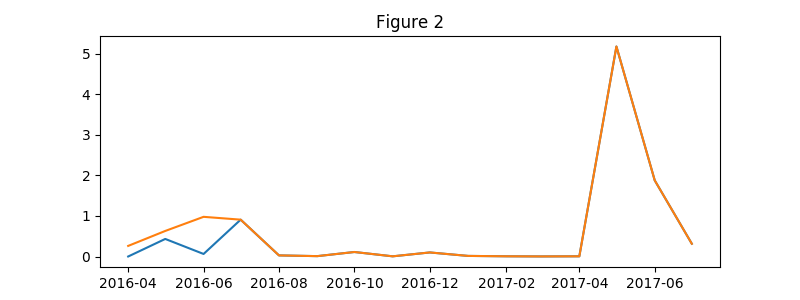

In [1118]:
plt.figure(figsize=(8,3))
xt = lambda x: (x.t, x)
plt.plot(*xt(diff(l6).sel(lead='obs').resample('MS','t', how='mean').mean('stations')), label='diff first')
plt.plot(*xt(diff(l6.resample('MS','t', how='mean').mean('stations')).sel(lead='obs')), label='mean first')
plt.gca().set_title('Figure 2');

In [782]:
pd.DataFrame([
    h.sel(order=3,lead='obs',x=('MS','12h')), 
    err_all(l6.sel(t=slice('2016-08', None)), ['diff', 'sample', 'space', 'abs', 'mean']).loc['obs', 'MS']],
    index=['original', 'first months removed'], columns=['mean of monthly means']).T

,original,first months removed
mean of monthly means,0.652631,0.638331


In [613]:
x = xr.open_dataarray('../../data/WRF/3d/RAINNC_5.nc').isel(Time = np.arange(24, 121, 24)).mean(['south_north', 'west_east'])
x5 = xr.concat((x.isel(Time = 0), x.diff('Time')), 'Time')

In [626]:
x = xr.open_dataarray('../../data/WRF/3d/RAINNC_6.nc').isel(Time = np.arange(24, 145, 24)).mean(['south_north', 'west_east'])
x6 = xr.concat((x.isel(Time = 0), x.diff('Time')), 'Time')

<IPython.core.display.Javascript object>


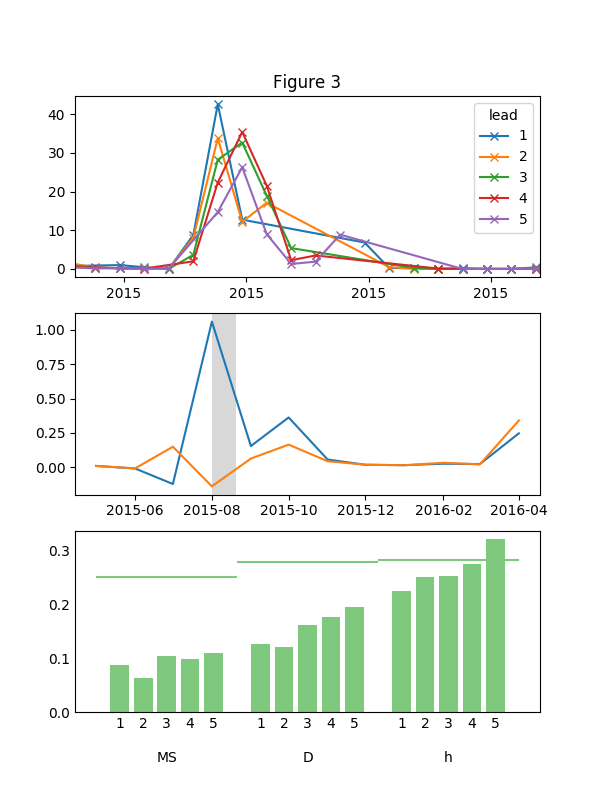

In [1119]:
fig, axs = plt.subplots(3, 1, figsize=(6,8))
axs[0].set_title('Figure 3')
# detail plot of daily mean model data
plt.sca(axs[0])
for i in np.arange(5):
    plt.plot(x5.XTIME[:, i], x5[:, i], 'x-', label=i+1)
axs[0].set_xlim('2015-08-01', '2015-08-20')
axs[0].set_xticks(np.arange(*axs[0].get_xlim())[2::5])
plt.legend(title='lead')

# monthly means
plt.sca(axs[1])
xt = lambda x: (x.t, x)
plt.plot(*xt(diff(l5).sel(lead='0').resample('MS','t', how='mean').mean('stations')), label='diff first')
plt.plot(*xt(diff(l5.resample('MS','t', how='mean').mean('stations')).sel(lead='0')), label='mean first')
axs[1].axvspan(*axs[0].get_xlim(), fc='gray', alpha=.3)

# remove the respective time interval from the statistics and replot bars
h1 = err_all(xr.concat((l5.sel(t=slice(None, '2015-08-01')), 
                       l5.sel(t=slice('2015-08-20', None))), 't'), ['diff', 'time', 'space', 'abs'])
plt.sca(axs[2])
bplot(xr.DataArray(h1[['MS', 'D', 'h']], dims=['lead', 'x']));

In [798]:
order_list2 = [['diff', 'space', 'time', 'abs'],
              ['diff', 'time', 'space', 'abs'],
              ['space', 'diff', 'time', 'abs'],
              ['time', 'diff', 'space', 'abs'],
              ['space', 'diff', 'abs', 'time'],
              ['time', 'diff', 'abs', 'space'],
              ['space', 'time', 'diff', 'abs'], 
              ['time', 'space', 'diff', 'abs']]
frames = [pd.concat([err_all(l.drop('mean', 'stations'), order) for l in [l5, l6]], 1, keys=['0h', '12h']) 
          for order in order_list2]
h2 = xr.concat([xr.DataArray(f.swaplevel(axis=1)[['MS', 'D', 'h']], dims=['lead', 'x']) for f in frames], 'order')

<IPython.core.display.Javascript object>


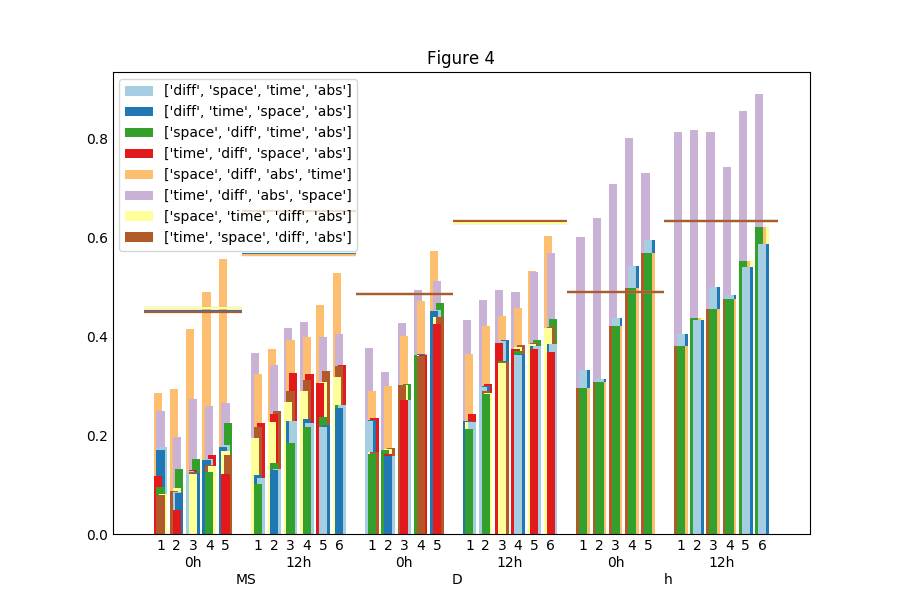

In [1120]:
fig = plt.figure(figsize=(9, 6))
bplot(h2, order_list2, 'upper left', 'Paired')
plt.gca().set_title('Figure 4');

**h**: Time-averaging makes no difference here (already hourly), but space-averaging before taking the difference.   
**diff before vs after time**: Time-averaging before differencing might lead to larger errors.   
**space after diff**: Not a huge difference   
**space after abs**: Obviously this contains spatial errors.

**Conclusion**: For aggregates, use *space, diff, time, abs*. My original was *time, space, diff, abs*, which does not account for the concurrency of (observation, simulation) pairs.

In [846]:
from scipy import interpolate as ip
from pyproj import Proj

def interp2Dn(lon, lat, x, sta, coords=['XTIME']):
    p = Proj(**dom3)
    g = affine(*p(lon.values, lat.values))
    xy = (np.arange(lon.shape[0]), np.arange(lon.shape[1]))
    order = x.dims.index('south_north') < x.dims.index('west_east')
    i, j = p(*sta[['lon', 'lat']].astype(float).values.T)
    co = np.roll(g(np.r_['0,2', [i, j]]).T, int(order), 1)
    d = list(set(x.dims) - {'south_north', 'west_east'})
    y = xr.concat([
        xr.concat([
            xr.DataArray(
                ip.interpn(xy, x.loc[{d[0]:a, d[1]:b}].values, co, 'linear'),
                coords=[('stations', sta.index)]
            ) for b in x[d[1]]], 
            pd.Index(x[d[1]], name = d[1])
        ) for a in x[d[0]]],
        pd.Index(x[d[0]], name = d[0])
    )
    for c in coords:
        y[c] = x[c]
    return y

In [847]:
# WRF linearly interpolated to station locations
i5 = conc(r, interp2Dn(lon, lat, a5, sta))*24
i6 = conc(r, interp2Dn(lon, lat, a6, sta))*24

In [1122]:
frames = [
    pd.concat([err_all(l.drop('mean', 'stations')) for l in [l5, l6]], 1, keys=['0h', '12h']),
    pd.concat([err_all(l.sel(stations='mean'), ['diff', 'time','abs']) 
                     for l in [l5, l6]], 1, keys=['0h', '12h']),
    pd.concat([err_all(l) for l in [i5, i6]], 1, keys=['0h', '12h']),
    pd.concat([pd.DataFrame({s: err(l, s, ['space', 'diff', 'time', 'abs']) for s in ['MS', 'D']}) 
               for l in [g5, g6]], 1, keys=['0h', '12h'])
]
frames[-1][('0h','h')] = np.nan
frames[-1][('12h','h')] = np.nan
h3 = xr.concat([xr.DataArray(f.swaplevel(axis=1)[['MS', 'D', 'h']], dims=['lead', 'x']) for f in frames], 'order')

<IPython.core.display.Javascript object>


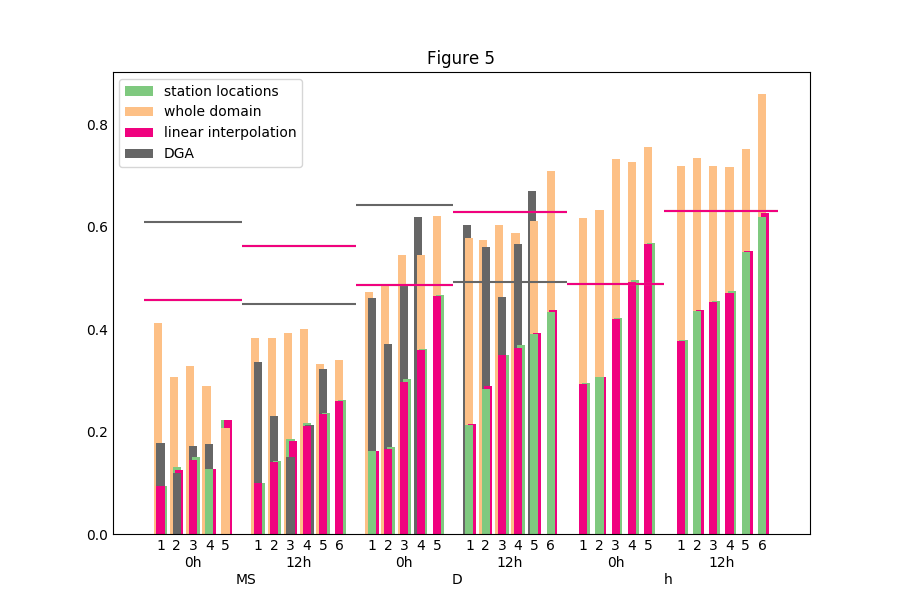

In [1123]:
fig = plt.figure(figsize=(9, 6))
bplot(h3, ['station locations', 'whole domain', 'linear interpolation', 'DGA'])
plt.gca().set_title('Figure 5');

<IPython.core.display.Javascript object>


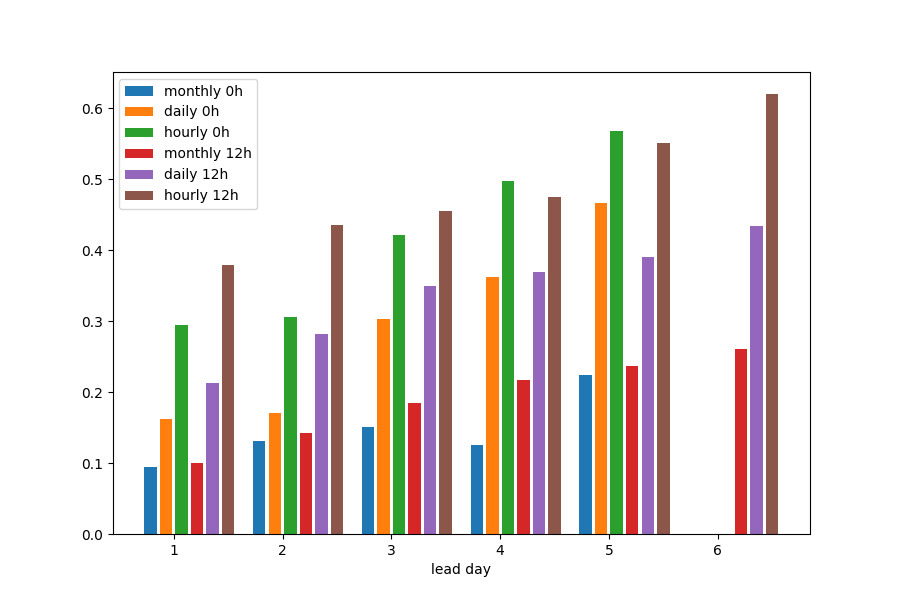

In [322]:
fig, ax = plt.subplots(figsize=(9, 6))
p = []
k = 0
for l in lh:
    for m in ['h', 'D', 'MS'][::-1]:
        p.append(plt.bar(np.arange(l.shape[1] - 1) * 7 + k, mae(l, m)))
        k += 1
ax.set_xticks(np.arange(6) * 7 + 1.5)
ax.set_xticklabels(np.arange(1, 7))
ax.set_xlabel('lead day')
plt.legend(p, ['monthly 0h', 'daily 0h', 'hourly 0h', 'monthly 12h', 'daily 12h', 'hourly 12h'], loc='upper left')

In [187]:
p5 = ps(x5)
p6 = ps(x6)
lm = [point_loss(offset_daily(r, o), k, 'MS') for o, k in [('4h', p5), ('16h', p6)]]
ld = [point_loss(offset_daily(r, o), k) for o, k in [('4h', p5), ('16h', p6)]]

<IPython.core.display.Javascript object>


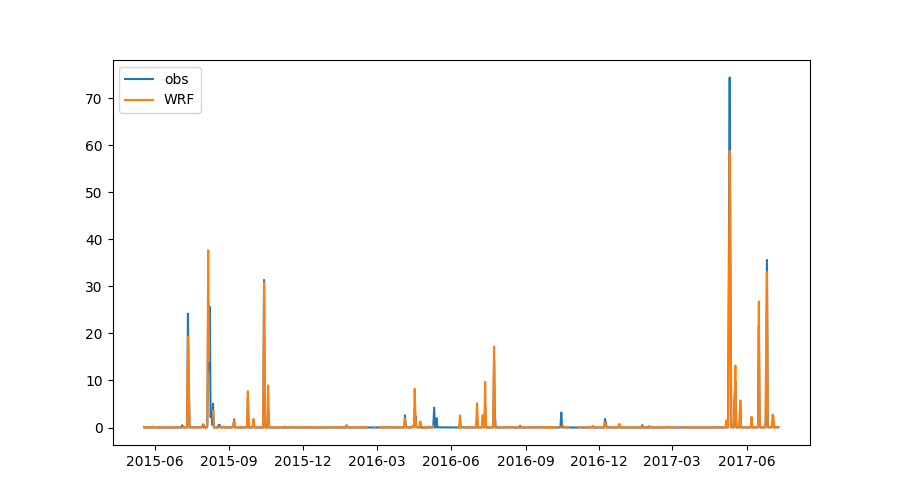

In [175]:
plt.figure(figsize=(9,5))
p = plt.plot(pd.concat([l[['obs', 0]] for l in ld]).sort_index())
plt.legend(p, ['obs', 'WRF'])

In [1106]:
def lplot(a, b, lead=0):
    c = b.sel(t=slice(str(a6.start.values[0]), None)).combine_first(
        a.sel(t=slice(str(a5.start.values[0]), None))
    ).sel(lead=['obs',lead]).mean('stations').resample('D', 't', how='mean')
    with catch_warnings():
        simplefilter('ignore')
        d = c.where(c>0.1)
    p = plt.plot(c.t, c)
    plt.gca().set_prop_cycle(None)
    plt.plot(d.t, d, marker='x', ls='none')
    return p

<IPython.core.display.Javascript object>


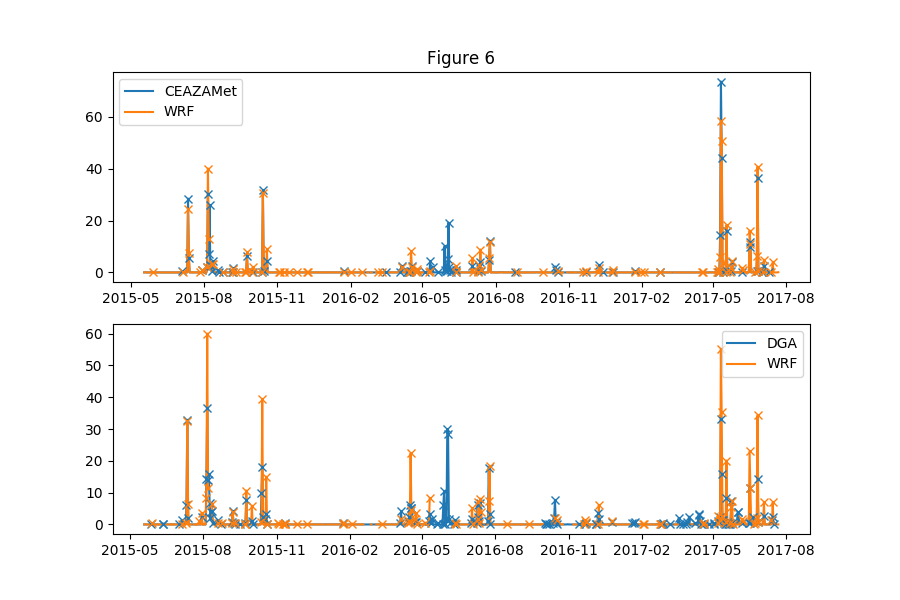

In [1124]:
fig, axs = plt.subplots(2, 1, figsize=(9,6))
plt.sca(axs[0])
p = lplot(l5, l6)
plt.legend(p, ['CEAZAMet', 'WRF'])
plt.sca(axs[1])
p = lplot(g5, g6)
plt.legend(p, ['DGA', 'WRF'])
axs[0].set_title('Figure 6');

In [ ]:
a = pd.concat([l[['obs', 0]] for l in ld]).sort_index()
plt.figure(figsize=(9,5))
p = plt.plot(a)
plt.plot(a[a>0.1]['obs'], marker='x', ls='none', color=p[0].get_color())
plt.plot(a[a>0.1][0], marker='x', ls='none', color=p[1].get_color())
plt.legend(p, ['obs', 'WRF'])

In [35]:
# DGA
m5 = ps(x5).mean('points')
m6 = ps(x6).mean('points')
lm = [loss(r, k) for k in [m5, m6]]
ld = [loss(r, k, 'D') for k in [m5, m6]]

<IPython.core.display.Javascript object>


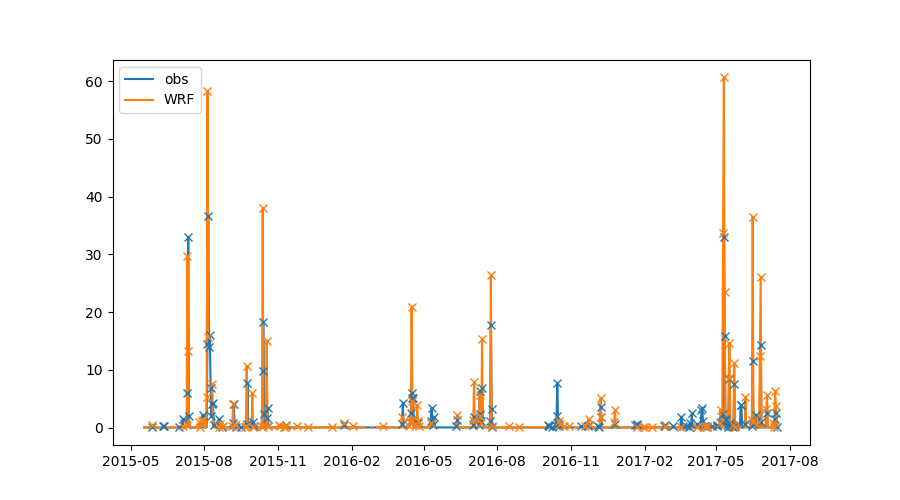

In [52]:
a = pd.concat([l[['obs', 0]] for l in ld]).sort_index()
plt.figure(figsize=(9,5))
p = plt.plot(a)
plt.plot(a[a>0.1]['obs'], marker='x', ls='none', color=p[0].get_color())
plt.plot(a[a>0.1][0], marker='x', ls='none', color=p[1].get_color())
plt.legend(p, ['obs', 'WRF'])

Same as above for DGA stations. Note that the average is over different points as for the CEAZA stations, hence the different values. Also, for DGA, I don't know what their time conventions are, so no attempt is made to align WRF results and DGA data temporally.

In [53]:
def mae(x):
    if isinstance(x, pd.DataFrame):
        return x.drop('obs', 1).add(-x['obs'], 0).abs().mean()
    else:
        return np.abs(x.mean('points').diff('type')).mean('time').values.flatten()

<IPython.core.display.Javascript object>


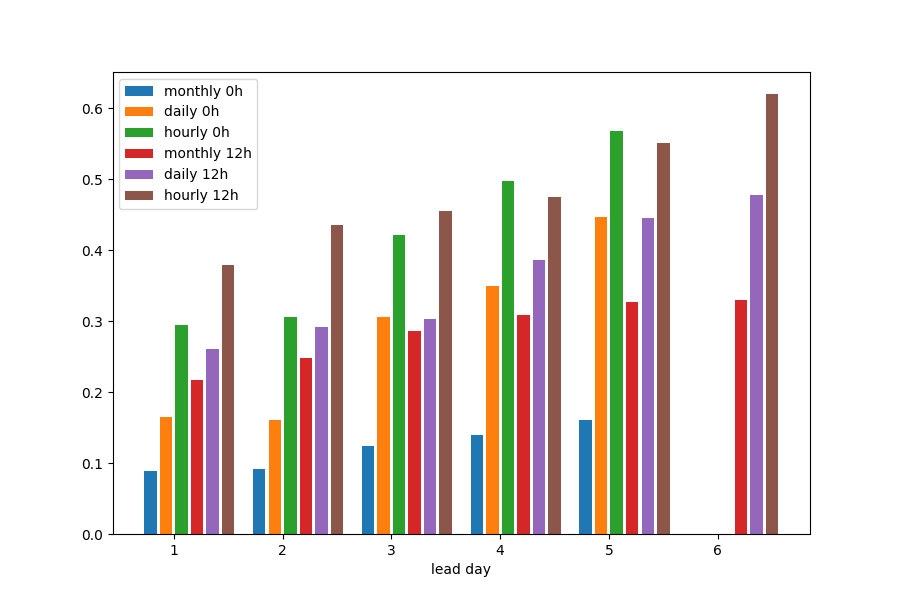

In [67]:
fig, ax = plt.subplots(figsize=(9, 6))
ps = []
for k, l in enumerate([lm[0], ld[0], lh[0], lm[1], ld[1], lh[1]]):
    ps.append(plt.bar(np.arange(l.shape[1] - 1) * 7 + k, mae(l)))
ax.set_xticks(np.arange(6) * 7 + 1.5)
ax.set_xticklabels(np.arange(1, 7))
ax.set_xlabel('lead day')
plt.legend(ps, ['monthly 0h', 'daily 0h', 'hourly 0h', 'monthly 12h', 'daily 12h', 'hourly 12h'], loc='upper left')

original plot with 'loss' (first station-averaging, then loss computation)

<IPython.core.display.Javascript object>


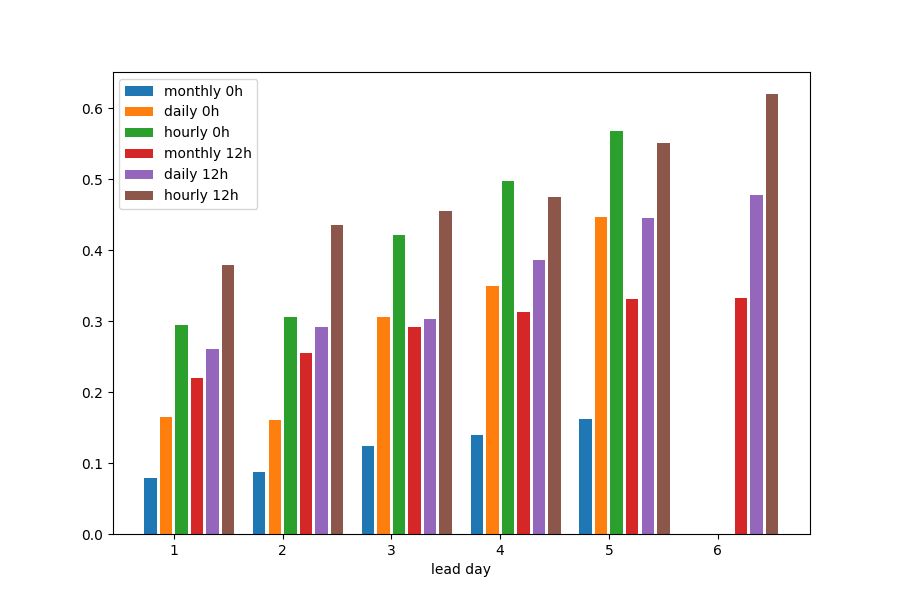

In [188]:
fig, ax = plt.subplots(figsize=(9, 6))
ps = []
for k, l in enumerate([lm[0], ld[0], lh[0], lm[1], ld[1], lh[1]]):
    e = mae(l)
    ps.append(plt.bar(np.arange(len(e)) * 7 + k, e))
ax.set_xticks(np.arange(6) * 7 + 1.5)
ax.set_xticklabels(np.arange(1, 7))
ax.set_xlabel('lead day')
plt.legend(ps, ['monthly 0h', 'daily 0h', 'hourly 0h', 'monthly 12h', 'daily 12h', 'hourly 12h'], loc='upper left')

same as above but with point_loss (station-wise loss, then averaging)

In [64]:
lm = [loss(offset_daily(r, o)/24, k) for o, k in [('-1d', m5), ('0d', m6)]]
ld = [loss(offset_daily(r, o)/24, k, 'D') for o, k in [('-1d', m5), ('0d', m6)]]

<IPython.core.display.Javascript object>


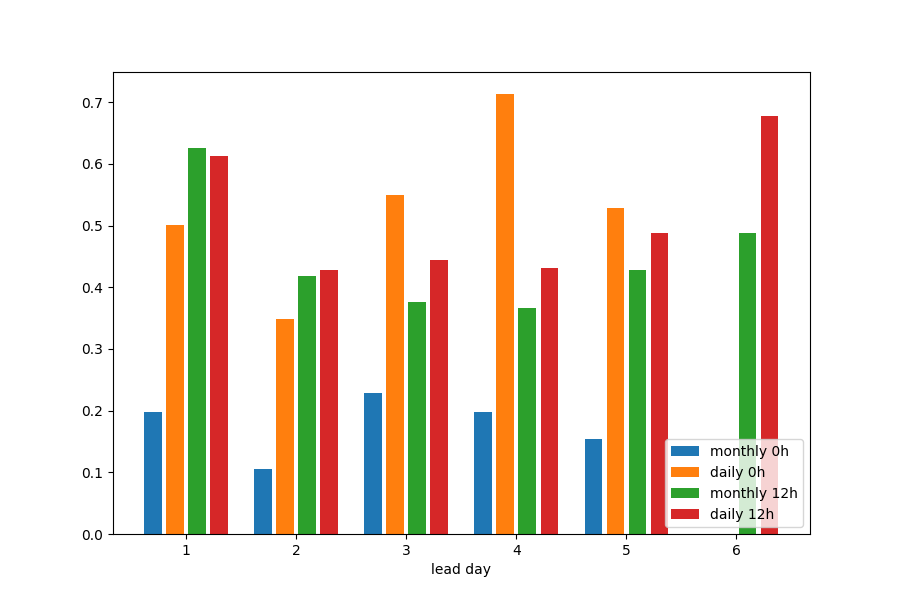

In [75]:
fig, ax = plt.subplots(figsize=(9, 6))
bars = [lm[0], ld[0], lm[1], ld[1]]
ps = []
for k, l in enumerate(bars):
    ps.append(plt.bar(np.arange(l.shape[1] - 1) * (len(bars) + 1) + k, mae(l)))
ax.set_xticks(np.arange(6) * (len(bars) + 1) + 1.5)
ax.set_xticklabels(np.arange(1, 7))
ax.set_xlabel('lead day')
plt.legend(ps, ['monthly 0h', 'daily 0h', 'monthly 12h', 'daily 12h'], loc='lower right')

<IPython.core.display.Javascript object>


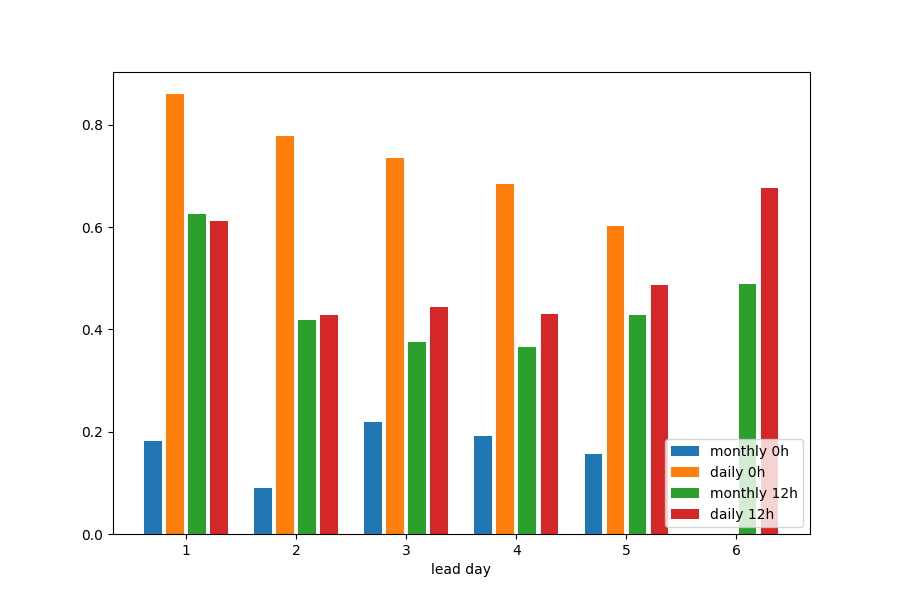

In [55]:
fig, ax = plt.subplots(figsize=(9, 6))
bars = [lm[0], ld[0], lm[1], ld[1]]
ps = []
for k, l in enumerate(bars):
    ps.append(plt.bar(np.arange(l.shape[1] - 1) * (len(bars) + 1) + k, mae(l)))
ax.set_xticks(np.arange(6) * (len(bars) + 1) + 1.5)
ax.set_xticklabels(np.arange(1, 7))
ax.set_xlabel('lead day')
plt.legend(ps, ['monthly 0h', 'daily 0h', 'monthly 12h', 'daily 12h'], loc='lower right')

Same as above with DGA data. Note that the large daily errors for the 0h runs have to do with the lack of alignment between WRF runs and the DGA data.

In [210]:
id5 = interp2Dn(lon, lat, x5, sta).mean('stations')
id6 = interp2Dn(lon, lat, x6, sta).mean('stations')
ih5 = interp2Dn(lon, lat, d5['RAINNC'], sta).mean('stations').diff('Time')
ih6 = interp2Dn(lon, lat, d6['RAINNC'].sel(start=slice(None, '2017-07-21')), sta).mean('stations').diff('Time')

In [215]:
lid = [loss(offset_daily(r, o), k, 'D') for o, k in [('-20h', id5), ('-8h', id6)]]
lih = [hourly(a, rs) * 24 for a in [ih5, ih6]]

<IPython.core.display.Javascript object>


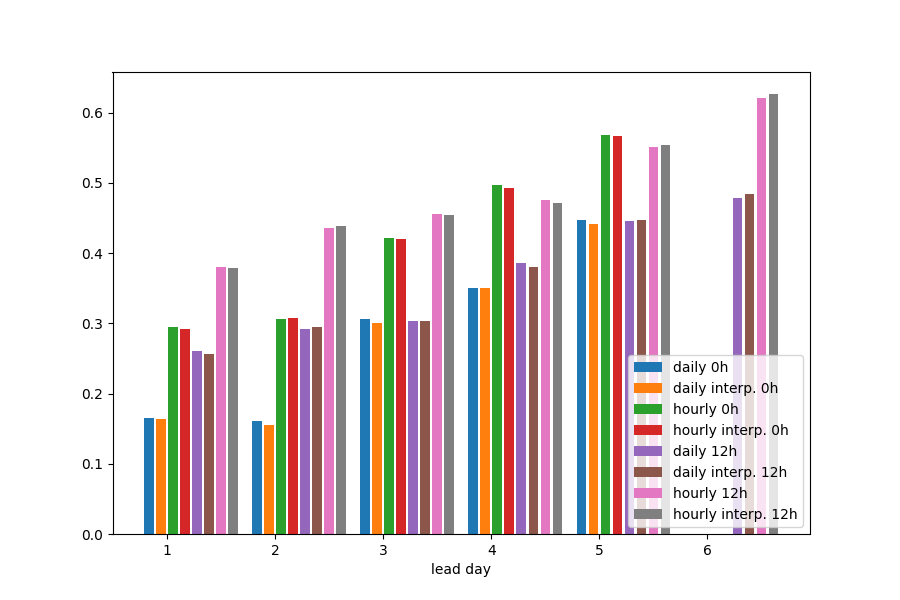

In [218]:
fig, ax = plt.subplots(figsize=(9, 6))
bars = [ld[0], lid[0], lh[0], lih[0], ld[1], lid[1], lh[1], lih[1]]
ps = []
for k, l in enumerate(bars):
    ps.append(plt.bar(np.arange(l.shape[1] - 1) * (len(bars) + 1) + k, mae(l)))
ax.set_xticks(np.arange(6) * (len(bars) + 1) + 1.5)
ax.set_xticklabels(np.arange(1, 7))
ax.set_xlabel('lead day')
plt.legend(ps, ['daily 0h', 'daily interp. 0h', 'hourly 0h', 'hourly interp. 0h',
               'daily 12h', 'daily interp. 12h', 'hourly 12h', 'hourly interp. 12h'], loc='lower right')

check if interpolation changes anything (no it doesn't)

In [9]:
p5 = point_loss(offset_daily(r,'4h'), ps(x5))
p6 = point_loss(offset_daily(r,'16h'), ps(x6))

In [56]:
from cartopy import crs
from cartopy.io import shapereader
import matplotlib.gridspec as gs

In [ ]:
proj = crs.LambertConformal(**cartopy_params(dom3))

In [57]:
coast = shapereader.Reader('../../data/geo/GSHHG/coast.shp')
border = shapereader.Reader('../../data/geo/GSHHG/border.shp')
rivers = shapereader.Reader('../../data/geo/GSHHG/river.shp')

In [12]:
def mplot(x, grid, cbar=True, vmin=None, vmax=None, title=None):
    ax = plt.subplot(grid, projection=proj)
    i, j = sta[['lon', 'lat']].astype(float).values.T
    p = ax.scatter(i, j, c=x.values, vmin=vmin, vmax=vmax)
    ax.add_geometries(coast.geometries(), crs=proj, facecolor='none', edgecolor='k')
    ax.add_geometries(rivers.geometries(), crs=proj, facecolor='none', edgecolor='b')
    ax.add_geometries(border.geometries(), crs=proj, facecolor='none', edgecolor='g', linewidth=.5)
    ax.set_extent((-72.2, -69.8, -32.5, -28.2), crs=proj)
    if title is not None:
        ax.set_title(title)
    if cbar:
        plt.colorbar(p, ax=ax)
    return p

In [90]:
p5 = point_loss(r, ps(x5), 'MS', time_dim='dim_0')
p6 = point_loss(r, ps(x6), 'MS', time_dim='dim_0')

In [76]:
def mae(x):
    return bias(np.abs(x))
def bias(x):
    return x.mean('time').squeeze()

same as below but with non-standardized colorbars

<IPython.core.display.Javascript object>


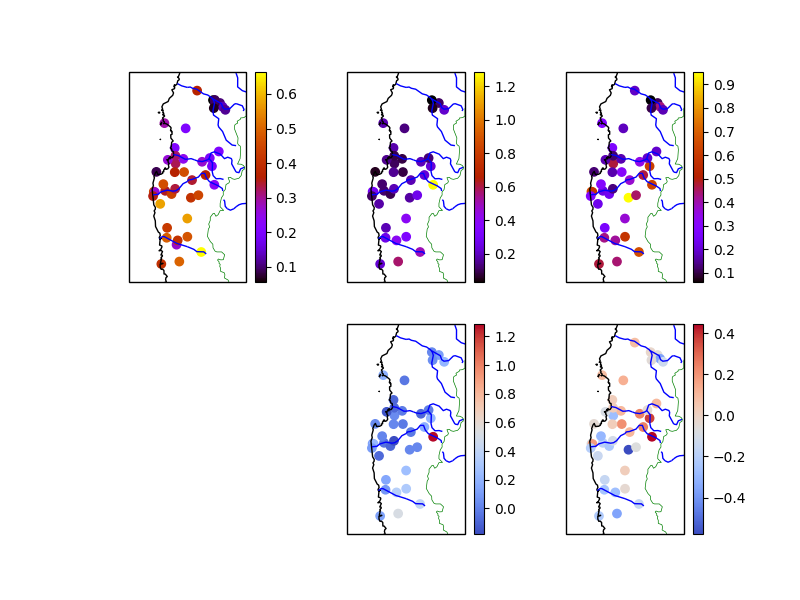

In [227]:
a = p5.isel(lead=0).diff('type')
b = p6.isel(lead=0).diff('type')

fig = plt.figure(figsize=(8, 6))
grid = gs.GridSpec(2, 3)

plt.set_cmap('gnuplot')
mplot(r.mean() * 24, grid[0, 0])
mplot(mae(a), grid[0, 1])
mplot(mae(b), grid[0, 2])

plt.set_cmap('coolwarm')
mplot(bias(a), grid[1, 1])
mplot(bias(b), grid[1, 2])

<IPython.core.display.Javascript object>


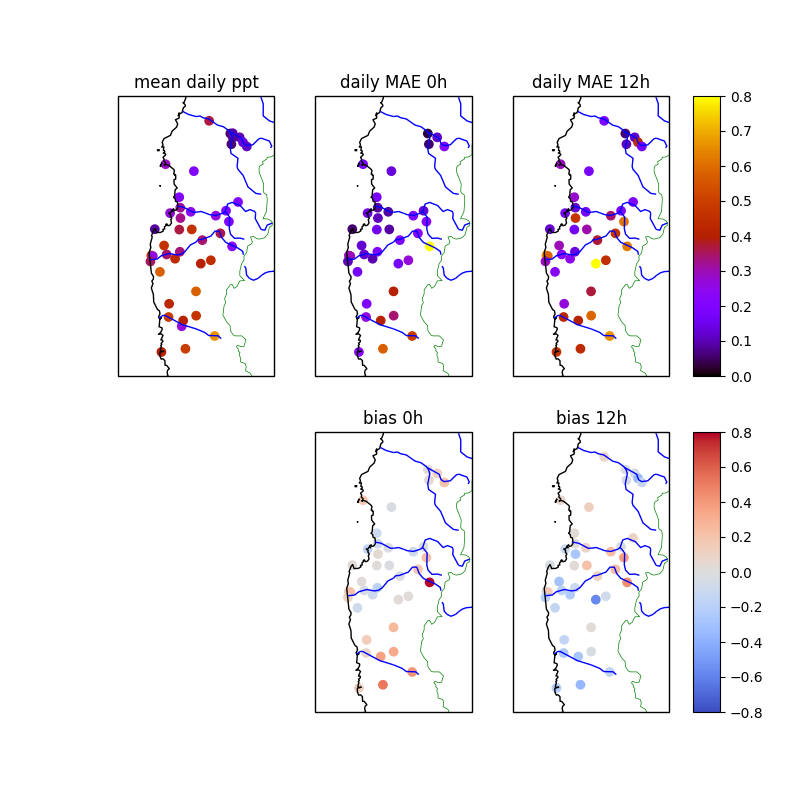

In [224]:
fig = plt.figure(figsize=(8, 8))

w = 6
grid = gs.GridSpec(2, 3*w+1)

plt.set_cmap('gnuplot')
mplot(r.mean() * 24, grid[0, :w], False, 0, .8, title='mean daily ppt')
mplot(mae(a), grid[0, w:2*w], False, 0, .8, title='daily MAE 0h')
p = mplot(mae(b), grid[0, 2*w:3*w], False, 0, .8, title='daily MAE 12h')
plt.colorbar(p, cax=plt.subplot(grid[0,3*w]))

plt.set_cmap('coolwarm')
mplot(bias(a), grid[1, w:2*w], False, -.8, .8, title='bias 0h')
p = mplot(bias(b), grid[1, 2*w:3*w], False, -.8, .8, 'bias 12h')
plt.colorbar(p, cax=plt.subplot(grid[1,3*w]))

<IPython.core.display.Javascript object>


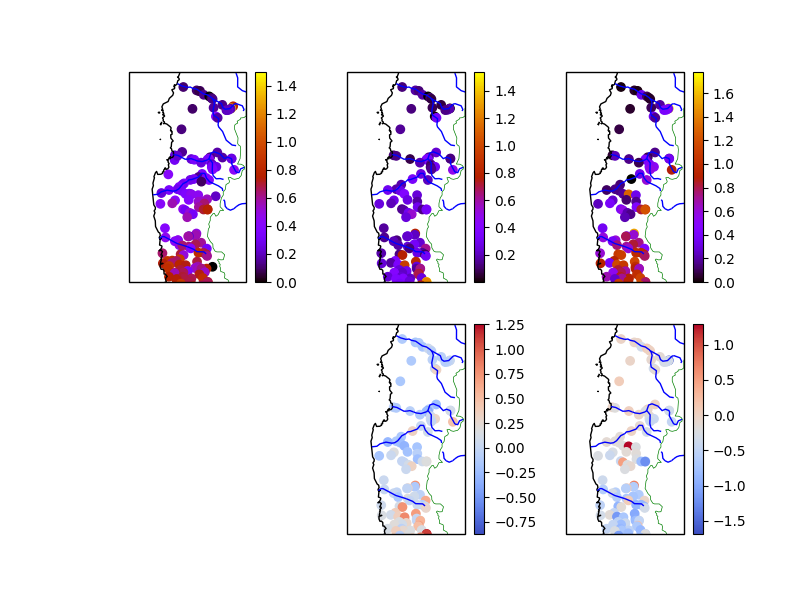

In [96]:
a = p5.isel(lead=1).diff('type')
b = p6.isel(lead=3).diff('type')

fig = plt.figure(figsize=(8, 6))
grid = gs.GridSpec(2, 3)

plt.set_cmap('gnuplot')
mplot(r.mean(), grid[0, 0])
mplot(mae(a), grid[0, 1])
mplot(mae(b), grid[0, 2])

plt.set_cmap('coolwarm')
mplot(bias(a), grid[1, 1])
mplot(bias(b), grid[1, 2])

<IPython.core.display.Javascript object>


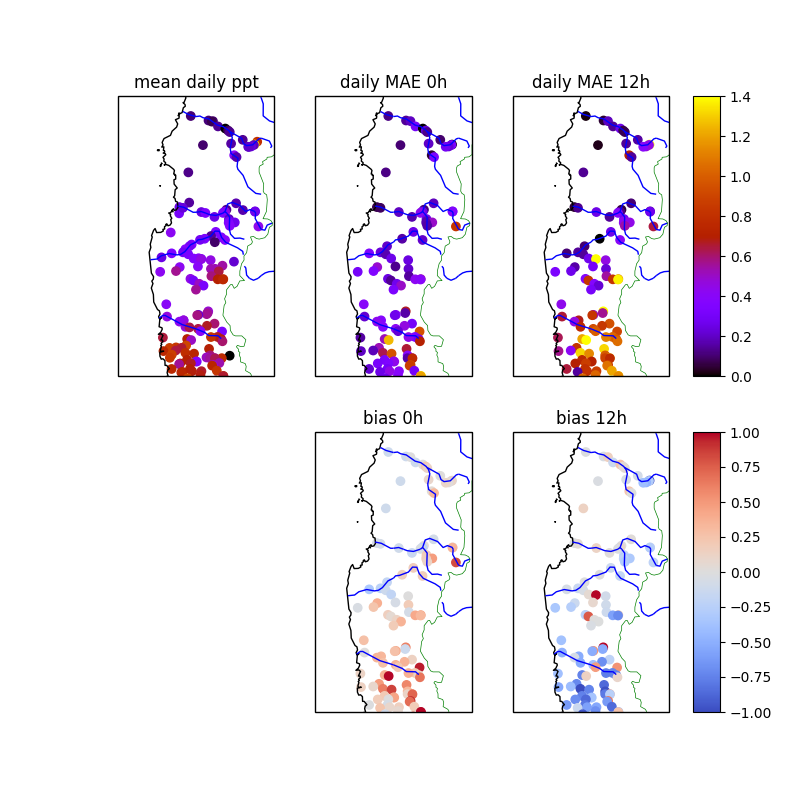

In [94]:
fig = plt.figure(figsize=(8, 8))

w = 6
grid = gs.GridSpec(2, 3*w+1)

plt.set_cmap('gnuplot')
mplot(r.mean(), grid[0, :w], False, 0, 1.4, title='mean daily ppt')
mplot(mae(a), grid[0, w:2*w], False, 0, 1.4, title='daily MAE 0h')
p = mplot(mae(b), grid[0, 2*w:3*w], False, 0, 1.4, title='daily MAE 12h')
plt.colorbar(p, cax=plt.subplot(grid[0,3*w]))

plt.set_cmap('coolwarm')
mplot(bias(a), grid[1, w:2*w], False, -1, 1, title='bias 0h')
p = mplot(bias(b), grid[1, 2*w:3*w], False, -1, 1, 'bias 12h')
plt.colorbar(p, cax=plt.subplot(grid[1,3*w]))

In [297]:
def nplot(station, ax):
    col = plt.rcParams['axes.prop_cycle'].by_key()['color']
    k = r.columns.get_level_values('station').get_loc(station)
    s = r[station].resample('D')
    a = s.mean() * 24
    a = a[a>0]
    b = a5[:,:24, i[k], j[k]].stack(t=('start', 'Time'))
    c = a6[:,:24, i[k], j[k]].stack(t=('start', 'Time'))
    ax.scatter(a.index, a, s=s.count(), c=col[0])
    b = b[b>0]
    ax.plot(b.XTIME, b.values, '+', c=col[1])
    c = c[c>0]
    ax.plot(c.XTIME, c.values, '+', c=col[2])
    ax.set_xlim(b.XTIME.values[0], c.XTIME.values[-1])

<IPython.core.display.Javascript object>


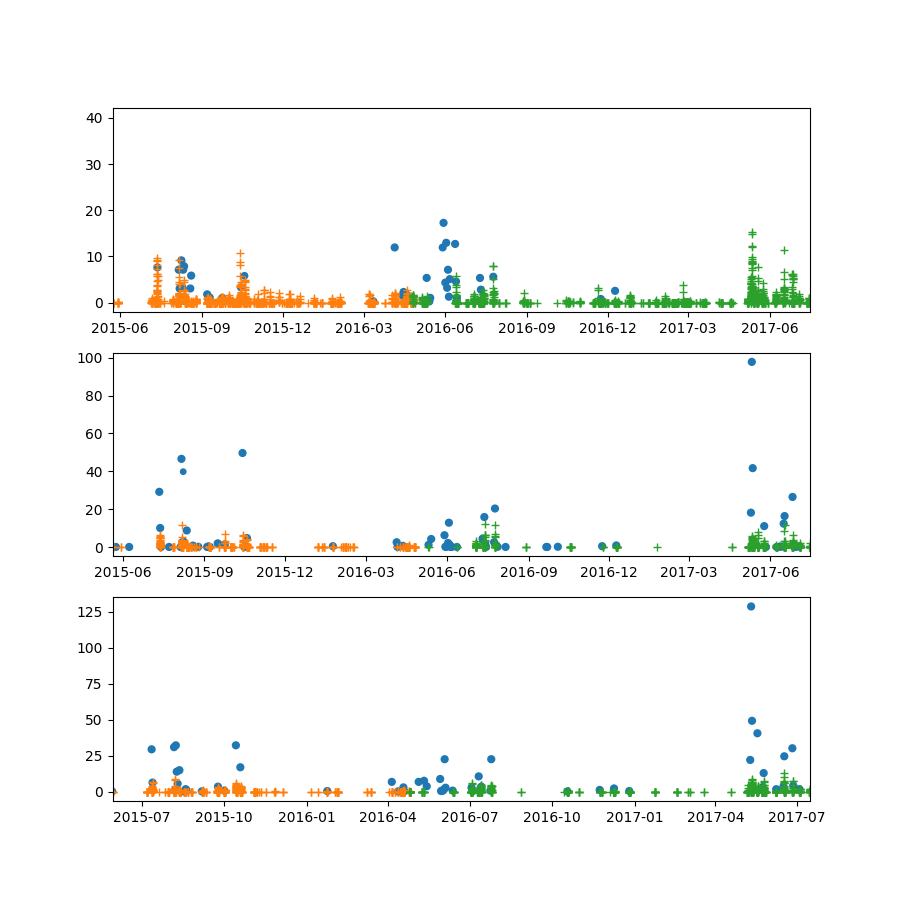

In [298]:
fig, axs = plt.subplots(3, 1, figsize=(9,9))
nplot('LAGHU', axs[0]) # Laguna Hurtado - tipping bucket in snow territory
nplot('INIA66', axs[1])
nplot('RPL', axs[2])

dots - observations (daily mean * 24, dot size = n obs)

In [200]:
with xr.open_mfdataset('../../data/fnl/ppt/*f0[6,9].nc') as ds:
    d6 = ds['APCP_P8_L1_GLL0_acc'].load()
    d9 = ds['APCP_P8_L1_GLL0_acc3h'].load()

In [225]:
def hour(x, h):
    d = pd.DatetimeIndex(x.initial_time0_hours.values)
    x.coords['date'] = ('initial_time0_hours', d.date.astype('datetime64'))
    x0 = x.loc[d.hour==h, :, :].swap_dims({'initial_time0_hours': 'date'})
    return x0

In [226]:
d0 = hour(d6, 0) + hour(d9, 0)
d1 = hour(d6, 12) + hour(d9, 12)

In [229]:
def split(x, i):
    return x.sel(date = slice('2016-04-25', None) if i else slice(None, '2016-04-24'))

In [167]:
def pplot(x, grid, cbar=True, vmin=None, vmax=None, title=None):
    ax = plt.subplot(grid, projection=proj)
    i, j = x.lon_0.values - 360, x.lat_0.values
    p = ax.pcolormesh(i, j, x.values, vmin=vmin, vmax=vmax)
    ax.add_geometries(coast.geometries(), crs=proj, facecolor='none', edgecolor='k')
    ax.add_geometries(rivers.geometries(), crs=proj, facecolor='none', edgecolor='b')
    ax.add_geometries(border.geometries(), crs=proj, facecolor='none', edgecolor='g', linewidth=.5)
    ax.set_extent((-72.2, -69.8, -32.5, -28.2), crs=proj)
    if title is not None:
        ax.set_title(title)
    if cbar:
        plt.colorbar(p, ax=ax)
    return p

<IPython.core.display.Javascript object>


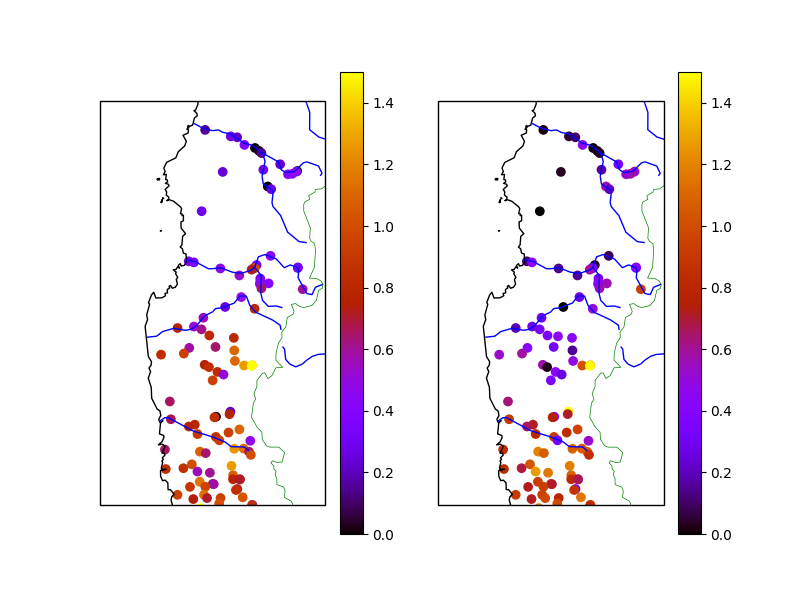

In [303]:
fig = plt.figure(figsize=(8, 6))
grid = gs.GridSpec(1, 2)
mplot(r['2015-07-08':'2016-04-24'].mean(), grid[0, 0], vmin=0, vmax=1.5)
mplot(r['2016-04-25':].mean(), grid[0, 1], vmin=0, vmax=1.5)

In [9]:
r0 = r['2015-07-08':'2016-04-24']
r1 = r['2016-04-25':]
R = r['2015-07-08':]

In [290]:
def hour(x, h):
    idx = x.index
    k = (idx.hour > 15) | (idx.hour < 2) if h else (idx.hour > 3) & (idx.hour < 14)
    return x.groupby(k).mean().loc[True]*9

<IPython.core.display.Javascript object>


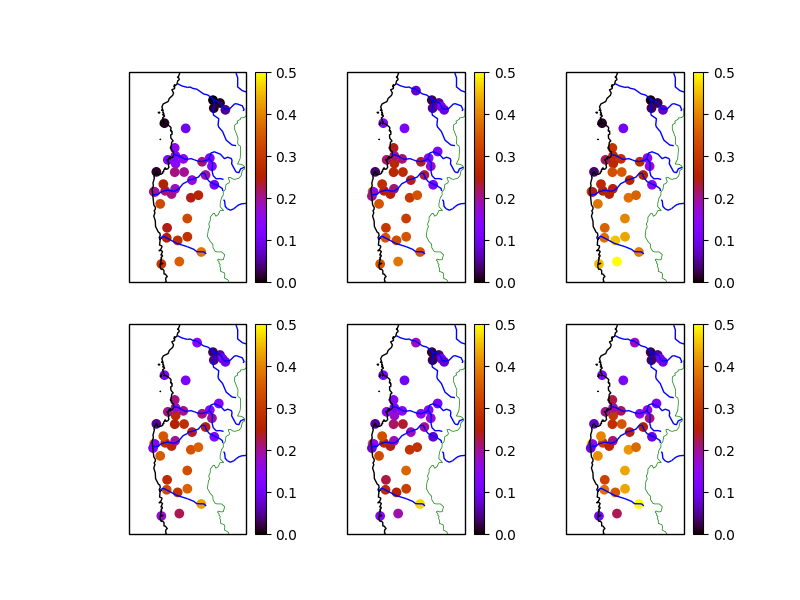

In [299]:
fig = plt.figure(figsize=(8, 6))
plt.set_cmap('gnuplot')
grid = gs.GridSpec(2, 3)
ma = .5
d = (d0 + d1) / 2
mplot(r0.mean()*9, grid[0, 0], vmin=0, vmax=ma)
mplot(r1.mean()*9, grid[1, 0], vmin=0, vmax=ma)
mplot(hour(R, 0), grid[0, 1], vmin=0, vmax=ma)
mplot(hour(R, 1), grid[1, 1], vmin=0, vmax=ma)
mplot(hour(r0, 0), grid[0, 2], vmin=0, vmax=ma)
mplot(hour(r1, 1), grid[1, 2], vmin=0, vmax=ma)

In [2]:
import sys
sys.path.append('../miniconda3/envs/iris/lib/python3.6/site-packages/')
import iris
import iris.plot as iplt
import iris.coord_categorisation as ccat
from datetime import datetime, timedelta
iris.FUTURE.netcdf_promote = True
iris.FUTURE.cell_datetime_objects = True

In [5]:
from geo import domain_bounds
sta = sta.loc[domain_bounds('../../data/WRF/3d/geo_em.d03.nc', sta[['lon', 'lat']].values)]

In [6]:
def adco(cube):
    ccat.add_day_of_year(cube, 'time', 'day')
    ccat.add_year(cube, 'time', 'year')
    ccat.add_hour(cube, 'time', 'hour')
    return cube
def xtr(cube, h):
    x = cube.copy().extract(iris.Constraint(hour = h))
    x.remove_coord('hour')
    return x
def split(x, a):
    crt = (lambda t: t > datetime(2016, 4, 24)) if a else (lambda t: t < datetime(2016, 4, 25))
    return x.extract(iris.Constraint(time = crt))
def mean(x):
    with catch_warnings():
        simplefilter('ignore')
        return x.collapsed('time', iris.analysis.MEAN)
def delay(cube, dt):
    x = cube.copy()
    t = x.coord(axis='t')
    d = x.coord_dims(t.name())[0]
    n = t.units.num2date(t.points) + dt
    x.remove_coord(t.name())
    x.add_dim_coord(
        iris.coords.DimCoord(t.units.date2num(n), 
                             units=t.units, 
                             **{s: getattr(t, s) for s in ['standard_name', 'long_name', 'var_name']}), 
        d)
    return x

In [48]:
with catch_warnings():
    simplefilter('ignore')
    c6 = adco(iris.load('../../data/fnl/ppt/gdas1.fnl0p25.f06.nc', 'Total precipitation')[0])
    c9 = adco(iris.load('../../data/fnl/ppt/gdas1.fnl0p25.f09.nc', 'Total precipitation')[0])
    c0 = (xtr(c6, 0) + xtr(c9, 0))
    c1 = (xtr(c6, 12) + xtr(c9, 12))
c = c0 + delay(c1, timedelta(hours=-12)) # shift the f09 files back to 0h initial time so iris will add them

In [241]:
def iplot(x, grid, vmin=None, vmax=None, cbar=True, title=None):
    plt.subplot(grid)
    with catch_warnings():
        simplefilter('ignore')
        p = iplt.pcolormesh(x, vmin=vmin, vmax=vmax)
    p.axes.set_extent((-72.2, -69.8, -32.5, -28.2))
    p.axes.add_geometries(coast.geometries(), crs.PlateCarree(), facecolor='none', edgecolor='k')
    p.axes.add_geometries(rivers.geometries(), crs.PlateCarree(), facecolor='none', edgecolor='b')
    p.axes.add_geometries(border.geometries(), crs.PlateCarree(), facecolor='none', edgecolor='g', linewidth=.5)
    if title is not None:
        p.axes.set_title(title)
    if cbar:
        plt.colorbar(p, ax=p.axes)
    return p

<IPython.core.display.Javascript object>


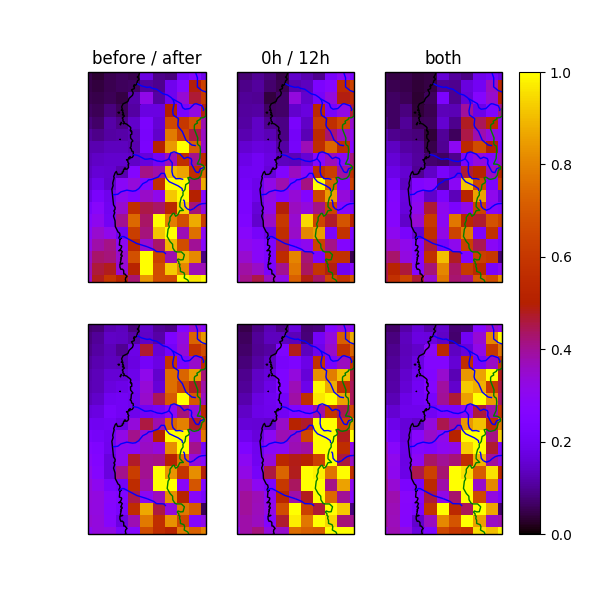

In [307]:
ma = 1
w = 6
plt.figure(figsize=(6, 6))
grid = gs.GridSpec(2, 3*w+1)
plt.set_cmap('gnuplot')
iplot(mean(split(c/2, 0)), grid[0, :w], 0, ma, False, 'before / after')
iplot(mean(split(c/2, 1)), grid[1, :w], 0, ma, False)
iplot(mean(c0), grid[0, w:2*w], 0, ma, False, '0h / 12h')
iplot(mean(c1), grid[1, w:2*w], 0, ma, False)
iplot(mean(split(c0, 0)), grid[0, 2*w:3*w], 0, ma, False, 'both')
p = iplot(mean(split(c1, 1)), grid[1, 2*w:3*w], 0, ma, False)
plt.colorbar(p, cax=plt.subplot(grid[:2, -1]))

In [7]:
def pint(x, datetime='D'):
    i = np.arange(len(sta))
    tc = x.coord(axis='t')
    t = tc.units.num2date(tc.points).astype('datetime64[{}]'.format(datetime))
    y = x.interpolate([('longitude', sta['lon']), ('latitude', sta['lat'])], 
                      iris.analysis.Linear(extrapolation_mode='mask'))
    return xr.DataArray(y.data[:, i, i], coords=[('date', t), ('points', i)])

In [298]:
def point_loss(obs, mod):
    o = xr.DataArray(obs.groupby(obs.index.date).sum())
    o.coords['points'] = ('dim_1', np.arange(len(o.dim_1)))
    o = o.swap_dims({'dim_1': 'points'}).rename({'dim_0': 'date'}).drop('dim_1')
    i = pd.DatetimeIndex(mod.date.values).intersection(pd.DatetimeIndex(o.date.values))
    return xr.concat((o.sel(date=i), mod.sel(date=i)), 'type').diff('type').squeeze()

In [74]:
proj = crs.PlateCarree()
def mplot(v, grid, vmin=None, vmax=None, cbar=True, title=None):
    ax = plt.subplot(grid, projection=proj)
    i, j = sta[['lon', 'lat']].astype(float).values.T
    vc = v.count('date')
    x, y = v.mean('date'), vc / vc.max() * 50
    p = ax.scatter(i, j, c=x.values, s=y.values, vmin=vmin, vmax=vmax)
    ax.add_geometries(coast.geometries(), crs=proj, facecolor='none', edgecolor='k')
    ax.add_geometries(rivers.geometries(), crs=proj, facecolor='none', edgecolor='b')
    ax.add_geometries(border.geometries(), crs=proj, facecolor='none', edgecolor='g', linewidth=.5)
    ax.set_extent((-72.2, -69.8, -32.5, -28.2), crs=proj)
    if title is not None:
        ax.set_title(title)
    if cbar:
        plt.colorbar(p, ax=ax)
    return p

In [ ]:
s = R[sta.index].copy()
s.index += np.timedelta64(4, 'h')
s0 = s[(s.index.hour > 0) & (s.index.hour < 10)]
s1 = s[(s.index.hour > 12) & (s.index.hour < 22)]

<IPython.core.display.Javascript object>


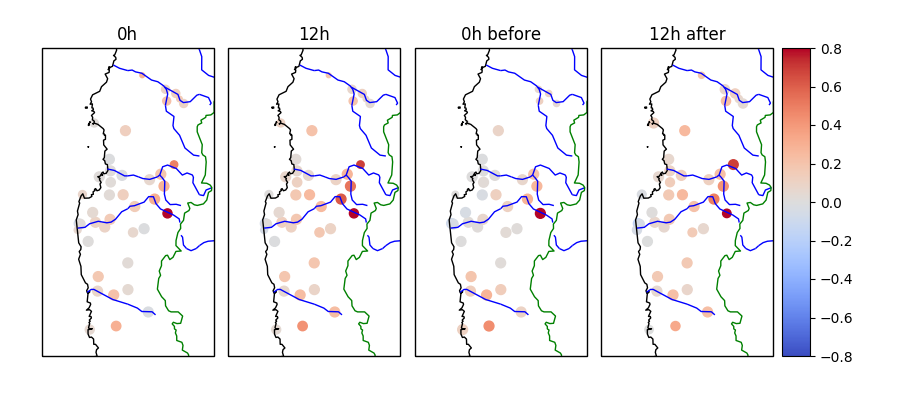

In [306]:
from matplotlib.figure import SubplotParams
ma = .8
w = 6
proj = crs.PlateCarree()
fig = plt.figure(figsize=(9,4), subplotpars=SubplotParams(left=0.04, right=0.9, wspace=0.1))
plt.set_cmap('coolwarm')
grid = gs.GridSpec(1, 4*w+1)
mplot(point_loss(s0, pint(c0)), grid[0, :w], -ma, ma, False, '0h')
mplot(point_loss(s1, pint(c1)), grid[0, w:2*w], -ma, ma, False, '12h')
mplot(point_loss(s0, pint(split(c0, 0))), grid[0, 2*w:3*w], -ma, ma, False, '0h before')
p = mplot(point_loss(s1, pint(split(c1, 1))), grid[0, 3*w:4*w], -ma, ma, False, '12h after')
plt.colorbar(p, cax=plt.subplot(grid[0, -1]))

[GFS uses the (2 class: rain and snow) Kessler microphysics scheme](http://www.dtcenter.org/GMTB/gfs_phys_doc/group__precip.html) (in WRF: mp_physics = 1) <cite data-cite="2031184/HX6KUHZA"></cite> with simplified computation of precipitation <cite data-cite="2031184/6VR7B9X8"></cite>.

Our WRF setup uses the WRF single moment 3-class scheme (WSM3, mp_physics = 3) <cite data-cite="2031184/ETWZMQAE"></cite>.

In [79]:
# if I only shift by three hours, the groupby action will appropriately apportion the 0:00h time to the previous day 
# (since it represents the accumulation between 23:00h and 0:00h).
q = R[sta.index].copy()
q.index += np.timedelta64(3, 'h')
s = q.groupby((q.index.date, q.index.hour // 6)).sum() # 6-h sums
s.index = [np.datetime64(d) + np.timedelta64(6*h, 'h') for d, h in s.index]
s.columns = np.arange(s.shape[1])
i = s.index.intersection(pd.DatetimeIndex(ci.date.values))
s = xr.DataArray(s, dims=['date', 'points'])

In [141]:
l = xr.concat((s, pint(c6, 'h')), pd.Index(['obs', 'mod'], name='type'))
lm = l.mean('points').groupby('type').apply(lambda g:g.groupby('date.date').sum())

<IPython.core.display.Javascript object>


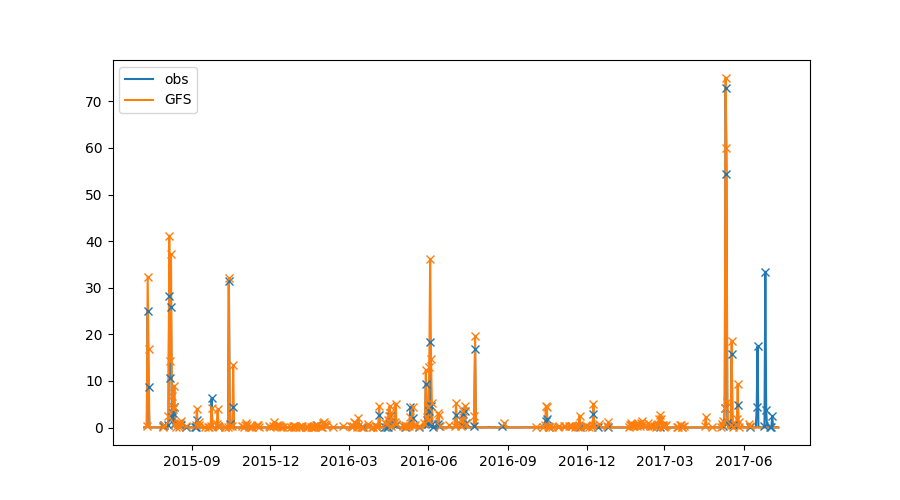

In [169]:
plt.figure(figsize=(9,5))
ab = lambda x: (lambda y: (y.date, y)) (x[x>0.1])
p = plt.plot(lm.date, lm.sel(type=['obs', 'mod']).T)
plt.plot(*ab(lm.sel(type='obs')), marker='x', ls='none', color=p[0].get_color())
plt.plot(*ab(lm.sel(type='mod')), marker='x', ls='none', color=p[1].get_color())
plt.legend(p, ['obs', 'GFS'])

In [124]:
s.mean()*4

<xarray.DataArray ()>
array(0.5771283383860257)

In [8]:
era = adco(iris.load('../../data/analyses/ERA-ppt.nc', iris.Constraint(time=lambda t: t > datetime(2004,1,30)))[0])
e = pint(era, 'h')
e['date'] = e.date - np.timedelta64(1, 'h') # so that 0:00h accumulation is counted toward previous day
e = e.groupby('points').apply(lambda g:g.groupby('date.date').sum()) * 1000

In [29]:
q = r[sta.index].copy()
q.index += np.timedelta64(3, 'h') # to include 0:00h accumulation in previous day!
s = q.groupby(q.index.date).sum() # daily sums
s = xr.DataArray(s, coords=[('date', s.index.astype('datetime64')), ('points', np.arange(s.shape[1]))])
l = xr.concat((s, e), pd.Index(['obs', 'mod'], name='type'))
lm = l['era'].mean('points').sel(date=slice('2004-01-31', None))

<IPython.core.display.Javascript object>


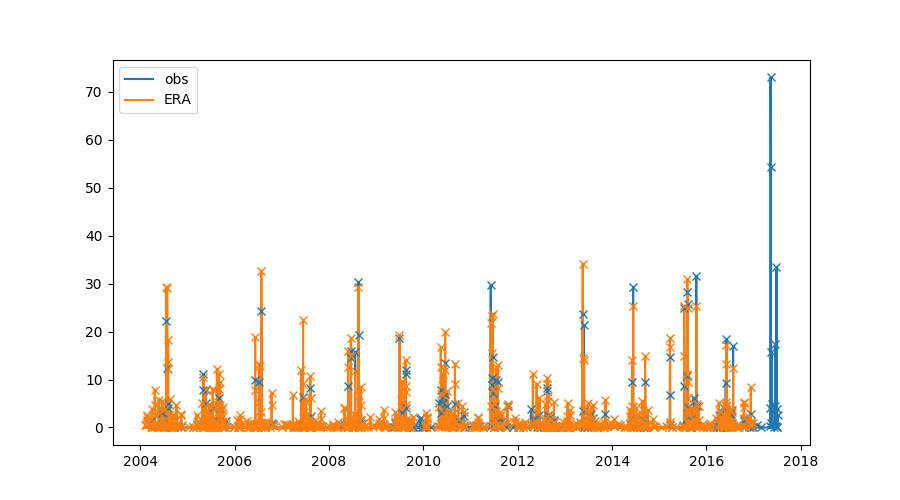

/usr/local/lib/python3.6/site-packages/xarray/core/variable.py:1143: RuntimeWarning: invalid value encountered in greater
  if not reflexive


In [30]:
plt.figure(figsize=(9,5))
ab = lambda x: (lambda y: (y.date, y)) (x[x>0.1])
p = plt.plot(lm.date, lm.sel(type=['obs', 'mod']).T)
plt.plot(*ab(lm.sel(type='obs')), marker='x', ls='none', color=p[0].get_color())
plt.plot(*ab(lm.sel(type='mod')), marker='x', ls='none', color=p[1].get_color())
plt.legend(p, ['obs', 'ERA'])

In [233]:
with xr.open_dataset('../../data/WRF/3d/RAINNC_5.nc') as d5:
    x5 = ps(d5['RAINNC'].isel(Time=24)).load()
    x5['date'] = ('start', np.array(pd.DatetimeIndex(x5.XTIME.values).date, dtype='datetime64'))
    x5 = x5.swap_dims({'start': 'date'}).drop(['Time', 'XLAT', 'XLONG', 'XTIME', 'start'])

In [252]:
c = pint(c6, 'h').groupby('points').apply(lambda g:g.groupby('date.date').sum()) # times are initial times here

In [253]:
g = xr.concat((s, c, e, x5), pd.Index(['obs', 'gfs', 'era', 'x5'], name='source')).sel(date=slice('2015-07-08', None))

<IPython.core.display.Javascript object>


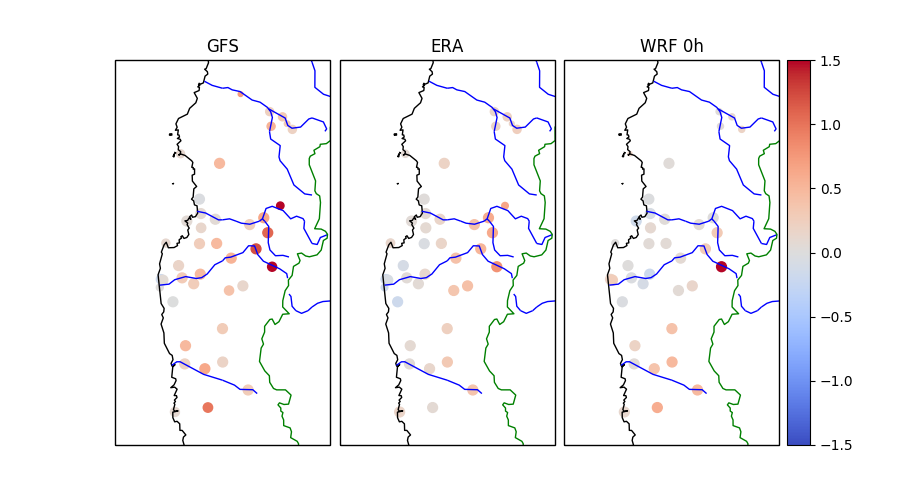

In [176]:
ma = 1.5
w = 8
plt.figure(figsize=(9, 5))
plt.set_cmap('coolwarm')
grid = gs.GridSpec(1, 3*w+1)
mplot(g.sel(source=['obs', 'gfs']).diff('source').squeeze(), grid[0, :w], -ma, ma, False, 'GFS')
mplot(g.sel(source=['obs', 'era']).diff('source').squeeze(), grid[0, w:2*w], -ma, ma, False, 'ERA')
p = mplot(g.sel(source=['obs', 'x5']).diff('source').squeeze(), grid[0, 2*w:3*w], -ma, ma, False, 'WRF 0h')
plt.colorbar(p, cax=plt.subplot(grid[0,-1]))

In [119]:
np.abs(l.mean('points')).groupby('date.hour').mean()

<xarray.DataArray (hour: 4)>
array([ 0.087214,  0.116676,  0.138463,  0.158209])
Coordinates:
  * hour     (hour) int64 0 6 12 18

In [83]:
np.abs(lm.diff('type').squeeze()).mean()

<xarray.DataArray ()>
array(0.2694016504264065)
Coordinates:
    type     <U3 'mod'

In [115]:
np.abs(l.mean('points').groupby('date.date').sum()).mean()

<xarray.DataArray ()>
array(0.4328472544475216)

In [107]:
np.abs(l.groupby('date.date').mean()*4).mean()

<xarray.DataArray ()>
array(0.4505789315002522)

In [256]:
np.abs(g.sel(source=['gfs', 'era', 'x5']).mean('points') - g.sel(source='obs').mean('points')).mean('date')

<xarray.DataArray (source: 3)>
array([ 0.408206,  0.277071,  0.188894])
Coordinates:
  * source   (source) object 'gfs' 'era' 'x5'

In [257]:
np.abs((g.sel(source=['gfs', 'era', 'x5']) - g.sel(source='obs')).mean('points')).mean('date')

<xarray.DataArray (source: 3)>
array([ 0.450014,  0.279961,  0.255144])
Coordinates:
  * source   (source) object 'gfs' 'era' 'x5'

In [258]:
(g.sel(source=['gfs', 'era', 'x5']) - g.sel(source='obs')).mean('date')

<xarray.DataArray (source: 3, points: 44)>
array([[ 0.138109,  0.060262, -0.030595,  0.249364,  1.089569,  0.066235,
         0.475342,  0.485419,  0.185817,  0.291806,       nan, -0.183119,
         0.067867,  0.28945 ,  0.016993,  0.295957,  0.725776,  0.394871,
         0.281162,  0.637403,  3.164128,  0.260771,  1.626293,  0.08324 ,
         1.22235 ,  0.111141,  0.32471 ,  0.30641 ,  0.224618,       nan,
         0.199437,       nan,  0.545828,  0.19971 ,  0.485832,  0.104961,
         0.543169,  0.112039, -0.00699 ,  0.64322 ,  0.164374,  0.139725,
         0.994958,  0.472944],
       [ 0.090806,  0.053017,  0.029097,  0.406076,  0.62102 ,  0.158575,
         0.160896,  0.088105,  0.320708,  0.375115,       nan, -0.176978,
        -0.062675,  0.233061, -0.168419,  0.05546 ,       nan,  0.355484,
         0.059183,  0.136809,  0.800045, -0.036209,  0.645149,  0.075196,
         0.526573,  0.074666,  0.213424,  0.167512,  0.159019,       nan,
         0.250088,       nan,  0.17257

In [249]:
def offset(r, dt):
    q = r[sta.index].copy()
    q.index += pd.Timedelta(dt)
    s = q.resample('D').mean()*24
    return xr.DataArray(s, coords=[('date', s.index), ('points', np.arange(s.shape[1]))])
res = [
    np.abs((x5 - offset(r, '4h')).mean('points')).mean('date'),
    np.abs((x5 - offset(r, '3h')).mean('points')).mean('date'),
    np.abs(offset(r, '4h').mean('points') - x5.mean('points')).mean('date'),
    np.abs(offset(r, '3h').mean('points') - x5.mean('points')).mean('date')
]
pd.DataFrame(res, index=['4h mean of diff', '3h mean of diff', '4h diff of mean','3h diff of mean'])

,0
4h mean of diff,0.227819
3h mean of diff,0.225711
4h diff of mean,0.164826
3h diff of mean,0.168016
